In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from src.features.feature_engineering_1 import *
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve, auc 
from sklearn.calibration import CalibrationDisplay

In [2]:
# Définition des années de train
years_train = ['2016', '2017', '2018', '2019']

In [3]:
# Chargement des données d'entrainement
data = get_all_season_data(years_train)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,x_coordinate,y_coordinate,empty_net,strength,home_team
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,-77.0,5.0,NaN,NaN,Ottawa Senators
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,86.0,13.0,NaN,NaN,Ottawa Senators
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,23.0,-38.0,NaN,NaN,Ottawa Senators
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,33.0,-15.0,NaN,NaN,Ottawa Senators
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,-34.0,28.0,NaN,NaN,Ottawa Senators


In [4]:
# Ajout des features de distance et d'angle
data = add_new_features(data)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,x_coordinate,y_coordinate,empty_net,strength,home_team,distance_to_net,shot_angle,is_goal,is_empty_net
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,-77.0,5.0,NaN,NaN,Ottawa Senators,13.0,23.0,0,0
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,86.0,13.0,NaN,NaN,Ottawa Senators,13.0,77.0,0,0
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,23.0,-38.0,NaN,NaN,Ottawa Senators,76.0,30.0,0,0
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,33.0,-15.0,NaN,NaN,Ottawa Senators,58.0,15.0,0,0
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,-34.0,28.0,NaN,NaN,Ottawa Senators,62.0,27.0,0,0


In [5]:
# Sélection de la caractéristique distance_to_net et des labels is_goal
df = data[['distance_to_net', 'is_goal']]
df.head()

,distance_to_net,is_goal
0,13.0,0
1,13.0,0
2,76.0,0
3,58.0,0
4,62.0,0


In [6]:
# Suppression des valeurs NaN
df = df.dropna()

In [7]:
y = df['is_goal'].values
X = df['distance_to_net'].values

In [8]:
# Split des données d'entrainement en train et val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Reshpae des array
X_train = X_train.reshape(X_train.shape[0], 1)
X_val = X_val.reshape(X_val.shape[0], 1)

**Question 1**

In [9]:
modele_base = LogisticRegression()
modele_base.fit(X_train, y_train)

LogisticRegression()

In [10]:
# Prédiction des données de val
y_pred = modele_base.predict(X_val)

In [11]:
confusion_matrix(y_val, y_pred)

array([[59188,     0],
       [ 6277,     0]], dtype=int64)

In [12]:
print('Accuracy :', accuracy_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))

Accuracy : 0.9041167035820667
Recall : 0.0


Nous remarquons que la précision du modèle est très bonne. Cependant ce résultat est trompeur car le modèle prédit que tous les exemples de l'ensemble de validation sont de la classe 0 (à l'aide de la matrice de confusion)

En calculant le Recall on se rend compte qu'il vaut 0. C'est un très très mauvais résultat.

Les problèmes possibles sont :
- Pas assez d'exemple de la classe 1 (pour un but)
- Seul la distance ne suffit pas pour prédire correctement 

**Question 2**

In [13]:
def plot_roc_curve(model, X_val, y_val):
    #https://www.statology.org/plot-roc-curve-python/
    #define metrics
    y_pred_proba = model.predict_proba(X_val)
    
    fpr, tpr, _ = roc_curve(y_val,  y_pred_proba[:, 1])
    auc = roc_auc_score(y_val,  y_pred_proba[:, 1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='red', linestyle='--', label='AUC=0.5')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Courbe ROC pour la probabilité de but')
    plt.legend(loc=4)
    plt.show()

In [14]:
def plot_goal_rate(model, X_val, y_val):

    y_pred_proba = model.predict_proba(X_val)
    proba_but = y_pred_proba[:, 1]
    
    percentiles = np.linspace(0, 100, 10)
    percentile_but = np.percentile(proba_but, np.linspace(0, 100, 11))
    taux_buts = []

    for i in range(len(percentiles)):

        percentile_inf = percentile_but[i]
        percentile_sup = percentile_but[i + 1]
        
        indices = np.where((proba_but >= percentile_inf) & (proba_but <= percentile_sup))
        
        goals_in_percentile = np.sum(y_val[indices])
        total_shots_percentile = y_val[indices].shape[0]
        taux_buts.append((goals_in_percentile / total_shots_percentile) * 100)


    plt.plot(np.linspace(0, 100, 10), taux_buts)
    plt.ylim(0, 100)
    plt.xlim(110, -10)
    plt.xlabel('Shot Probability model percentile')
    plt.ylabel('Goals / (Goals + Shots)')
    plt.title('Goal Rate')
    plt.show()

In [15]:
def plot_cumulative_percent_goal(model, X_val, y_val):

    y_pred_proba = model.predict_proba(X_val)
    proba_but = y_pred_proba[:, 1]
    
    percentiles = np.linspace(0, 100, 10)
    percentile_but = np.percentile(proba_but, np.linspace(0, 100, 10))
    proportions_buts = []

    for i in range(len(percentiles)):

        percentile_i = percentile_but[i]
        
        indices = np.where(proba_but <= percentile_i)
        
        goals_in_percentile = np.sum(y_val[indices])
        
        total_shots_percentile = np.sum(y_val)

        proportions_buts.append((goals_in_percentile / total_shots_percentile) * 100)

    plt.plot(np.linspace(100, 0, 10), proportions_buts)
    plt.ylim(0, 110)
    plt.xlim(110, -10)
    plt.xlabel('Shot Probability model percentile')
    plt.ylabel('Proportion')
    plt.title('Cumulative % of goals')
    plt.show()

In [16]:
def plot_fiability_diagram(model, X_val, y_val):

    y_pred_proba = model.predict_proba(X_val)
    proba_but = y_pred_proba[:, 1]
    
    disp = CalibrationDisplay.from_predictions(y_val, proba_but)
    plt.show()

In [17]:
# Prédiction des proba sur les données de val
y_pred_proba = modele_base.predict_proba(X_val)

**2-a**

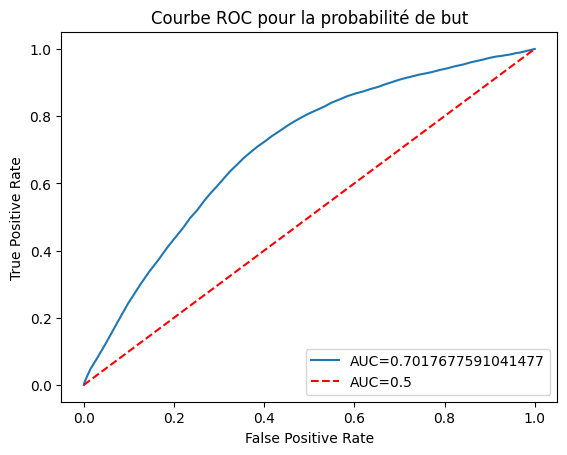

In [18]:
plot_roc_curve(modele_base, X_val, y_val)

**2-b**

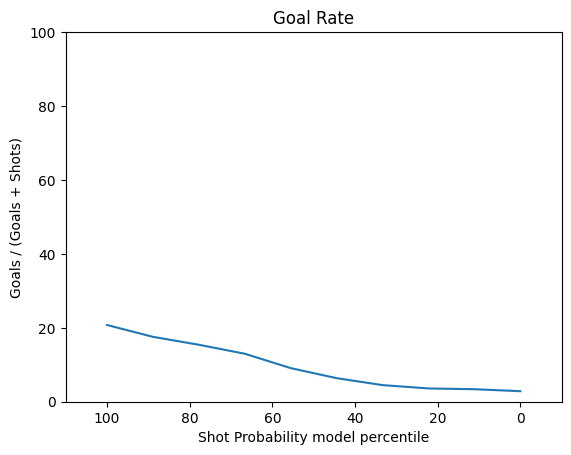

In [19]:
plot_goal_rate(modele_base, X_val, y_val)

**2c**

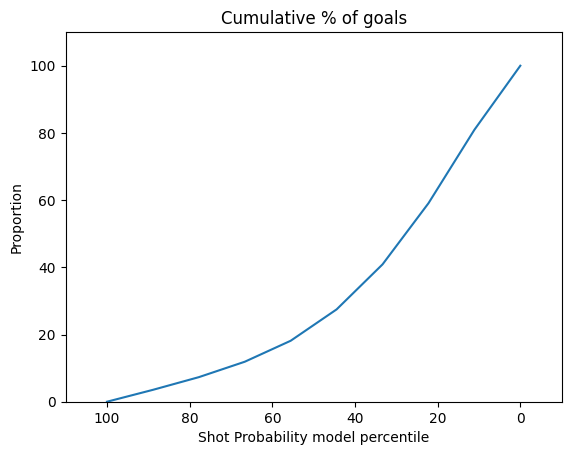

In [20]:
plot_cumulative_percent_goal(modele_base, X_val, y_val)

**2d**

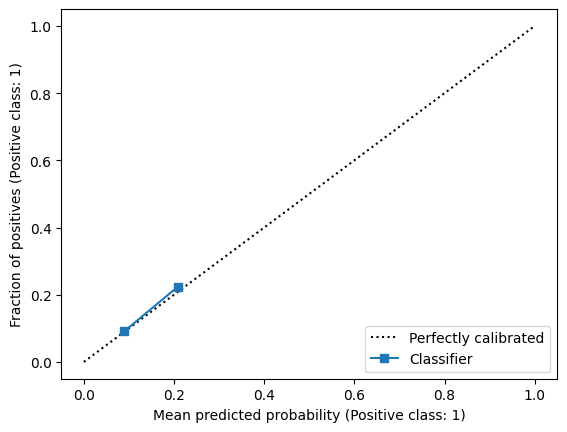

In [21]:
plot_fiability_diagram(modele_base, X_val, y_val)